<a href="https://colab.research.google.com/github/aiscience-22/UA_War/blob/olgap%2Fmachine_learning_0.06/deep_learning_quote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs latest version of TensorFlow 2.X 
# !pip install --upgrade tensorflow

In [1]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import datetime
from datetime import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import tensorflow as tf

In [2]:
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://securit

In [20]:
# Add drivers to Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [21]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://uaresources.s3.us-west-1.amazonaws.com/sentiment_joined_events_twitter_post_ml.csv"

spark.sparkContext.addFile(url)
text_df = spark.read.csv(SparkFiles.get("sentiment_joined_events_twitter_post_ml.csv"), sep=",", header=True, inferSchema=True)


# Show DataFrame
text_df.show()

+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|_c0|       username|following|followers|totaltweets|usercreatedts|tweetcreatedts|retweetcount|            hashtags|language|favorite_count|is_retweet|is_quote_status|extractedts|weekofyear|date_published|search_result| weight|        cleaned_text|            negative|             neutral|            positive|
+---+---------------+---------+---------+-----------+-------------+--------------+------------+--------------------+--------+--------------+----------+---------------+-----------+----------+--------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+
|  0|      WashTimes|   1893.0| 417389.0|   335685.0|   2008-05-

# Exploring the taken data

In [29]:
# Convert DataFrame to Pandas
joined_data_df = text_df.toPandas()
print(joined_data_df.shape)
joined_data_df.head(5)

(713009, 22)


,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,cleaned_text,negative,neutral,positive
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,democrats urge biden to counter pain at pump w...,0.222473,0.747085,0.030443
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,now is the time to annex cuba just sayin,0.078324,0.799905,0.121771
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,just grasping at straws here but does anyone h...,0.147500,0.824443,0.028057
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,this is huge russia will be expelled from the ...,0.883955,0.109929,0.006116
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,None,2022-02-26,8.0,2022-02-26,106000.0,0.000533,please take care,0.063437,0.643451,0.293113


In [30]:
# Change the dtypes of tweetcreatedts
joined_data_df["tweetcreatedts"] = pd.to_datetime(joined_data_df["tweetcreatedts"])

# drop the row with any NaT values in the tweetcreatedts column
joined_data_df = joined_data_df.dropna(axis=0, subset=['tweetcreatedts']) 
joined_data_df.shape

(713008, 22)

In [31]:
# convert text to text lenght and drop the text
joined_data_df['text_length']  = joined_data_df['cleaned_text'].str.len()
joined_data_df.drop("cleaned_text", axis=1, inplace=True)

In [32]:
# Change object type to boolean for columns 'is_retweet' and 'is_quote_status'
joined_data_df["is_retweet"] = joined_data_df['is_retweet'].astype(bool)
joined_data_df["is_quote_status"] = joined_data_df['is_quote_status'].astype(bool)
# Replace boolean columns
joined_data_df['is_retweet'] = joined_data_df['is_retweet'].astype(int)
joined_data_df['is_quote_status'] = joined_data_df['is_quote_status'].astype(int)
joined_data_df.head()

,_c0,username,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,hashtags,language,...,is_quote_status,extractedts,weekofyear,date_published,search_result,weight,negative,neutral,positive,text_length
0,0,WashTimes,1893.0,417389.0,335685.0,2008-05-05,2022-02-26,0.0,"[{'text': 'UkraineCrisis', 'indices': [102, 11...",en,...,0,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.222473,0.747085,0.030443,77.0
1,1,jacarroll,64.0,254.0,110.0,2008-01-07,2022-02-26,0.0,"[{'text': 'StandWithUkriane', 'indices': [58, ...",en,...,0,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.078324,0.799905,0.121771,40.0
2,2,axelk,5766.0,5329.0,119448.0,2007-06-14,2022-02-26,4.0,[],en,...,0,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.147500,0.824443,0.028057,138.0
3,3,ds2719,294.0,172.0,15270.0,2007-07-21,2022-02-26,894.0,[],en,...,0,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.883955,0.109929,0.006116,220.0
4,4,scholar_at_arms,975.0,75.0,1988.0,2008-09-26,2022-02-26,0.0,"[{'text': 'KyivDefiant', 'indices': [18, 30]},...",en,...,0,2022-02-26,8.0,2022-02-26,106000.0,0.000533,0.063437,0.643451,0.293113,16.0


In [33]:
# Drop the not needed column
joined_data_df.drop("username", axis=1, inplace=True)
joined_data_df.drop("usercreatedts", axis=1, inplace=True)
joined_data_df.drop("language", axis=1, inplace=True)
joined_data_df.drop("favorite_count", axis=1, inplace=True)
joined_data_df.drop("extractedts", axis=1, inplace=True)
joined_data_df.drop("weekofyear", axis=1, inplace=True)
joined_data_df.drop("neutral", axis=1, inplace=True)
joined_data_df.drop("positive", axis=1, inplace=True)
joined_data_df.drop("search_result", axis=1, inplace=True)
joined_data_df.drop("retweetcount", axis=1, inplace=True)
joined_data_df.drop("date_published", axis=1, inplace=True)
joined_data_df.drop("hashtags", axis=1, inplace=True)

In [34]:
# Check data types
joined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713008 entries, 0 to 713007
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   _c0              713008 non-null  int32         
 1   following        713008 non-null  float64       
 2   followers        713008 non-null  float64       
 3   totaltweets      713008 non-null  float64       
 4   tweetcreatedts   713008 non-null  datetime64[ns]
 5   is_retweet       713008 non-null  int64         
 6   is_quote_status  713008 non-null  int64         
 7   weight           710366 non-null  float64       
 8   negative         713008 non-null  float64       
 9   text_length      712997 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(1), int64(2)
memory usage: 57.1 MB


In [35]:
# Convert datetime from object to dtype

joined_data_df["tweetcreatedts"] = pd.to_numeric(joined_data_df.index, downcast='float')

print(joined_data_df["tweetcreatedts"])

0              0.0
1              1.0
2              2.0
3              3.0
4              4.0
            ...   
713003    713003.0
713004    713004.0
713005    713005.0
713006    713006.0
713007    713007.0
Name: tweetcreatedts, Length: 713008, dtype: float64


In [36]:
# get the shape of the new DataFrame
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

713008 rows and 10 columns


In [37]:
# Drop the null rows
joined_data_df = joined_data_df.dropna()
print(f"{joined_data_df.shape[0]} rows and {joined_data_df.shape[1]} columns")

710355 rows and 10 columns


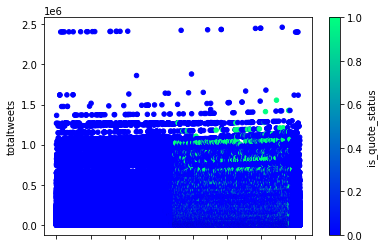

In [38]:
# Plotting the data
joined_data_df.plot.scatter(x="tweetcreatedts", y="totaltweets", c="is_quote_status", colormap="winter")

In [39]:
# Convert datetime to float

# time_df["tweetcreatedts"] = pd.to_numeric(joined_data_df.index, downcast='float')

joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(str)
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].str.replace('-', '')
joined_data_df['tweetcreatedts'] = joined_data_df['tweetcreatedts'].astype(float)
print(joined_data_df["tweetcreatedts"])

0              0.0
1              1.0
2              2.0
3              3.0
4              4.0
            ...   
713003    713003.0
713004    713004.0
713005    713005.0
713006    713006.0
713007    713007.0
Name: tweetcreatedts, Length: 710355, dtype: float64


# Standartization Data

In [40]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
scaler.fit(joined_data_df)

# Scale the data
scaled_data = scaler.transform(joined_data_df)

# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, columns=joined_data_df.columns)
transformed_scaled_data.head(5)

,_c0,following,followers,totaltweets,tweetcreatedts,is_retweet,is_quote_status,weight,negative,text_length
0,-1.730995,-0.177340,0.689392,1.330729,-1.730995,-0.645473,-0.222816,-0.78303,-0.542880,-0.925411
1,-1.730990,-0.298441,-0.101081,-0.678497,-1.730990,-0.645473,-0.222816,-0.78303,-0.974009,-1.446835
2,-1.730985,0.079098,-0.091464,0.036029,-1.730985,-0.645473,-0.222816,-0.78303,-0.767114,-0.065765
3,-1.730980,-0.283213,-0.101236,-0.587728,-1.730980,-0.645473,-0.222816,-0.78303,1.435525,1.089825
4,-1.730975,-0.238122,-0.101420,-0.667253,-1.730975,-0.645473,-0.222816,-0.78303,-1.018536,-1.785056


#  What does the distribution look like

In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the Probability Density Function (PDF) of a random variable. This function uses Gaussian kernels and includes automatic bandwidth determination.

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa7ca0e8310> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


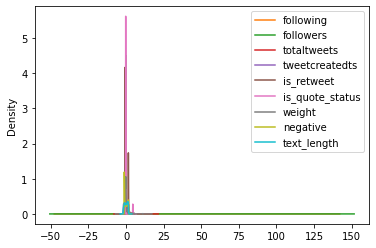

In [41]:
# Generate Kernel Density Estimate plot using Gaussian kernels, using the Density method to fing out

ax = transformed_scaled_data.plot.kde()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa77e2279d0> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


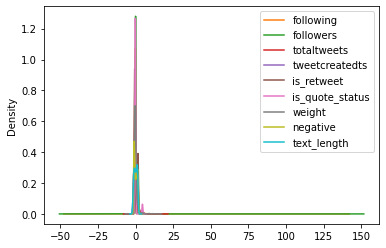

In [42]:
# Using a small bandwidth value 
ax = transformed_scaled_data.plot.kde(bw_method=0.3)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa7d51c5b10> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


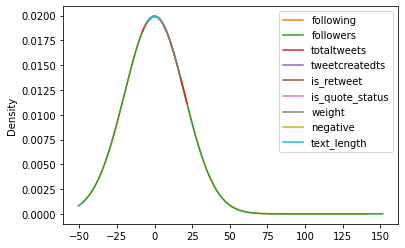

In [43]:
# Using a large bandwidt value
ax = transformed_scaled_data.plot.kde(bw_method=20)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fa7db48e9d0> has a label of '_c0' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


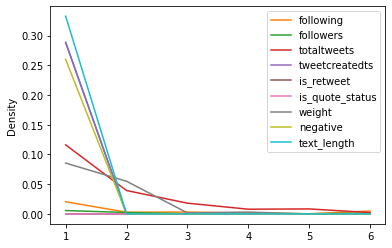

In [44]:
# Determine the evaluation points for the plot of the estimated PDF
ax = transformed_scaled_data.plot.kde(ind=[1, 2, 3, 4, 5, 6])

# Use Deep Learning Model

In [45]:
# Split our preprocessed data into our features and target arrays
y = transformed_scaled_data["is_quote_status"].values
X = transformed_scaled_data.drop(["is_quote_status"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [47]:
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Compile the model
# tf.keras.losses.MeanAbsolutePercentageError(
#    reduction="auto", name="mean_absolute_percentage_error")
	
# nn.compile(loss='mean_squared_error', optimizer="adam", metrics=["accuracy"])
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
# Fit the model to the training data
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)
# fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
16649/16649 [==============================] - 33s 2ms/step - loss: -19339.5938 - accuracy: 0.0000e+00
Epoch 2/100
16649/16649 [==============================] - 33s 2ms/step - loss: -214125.9062 - accuracy: 0.0000e+00
Epoch 3/100
16649/16649 [==============================] - 33s 2ms/step - loss: -799617.6875 - accuracy: 0.0000e+00
Epoch 4/100
16649/16649 [==============================] - 33s 2ms/step - loss: -1981463.7500 - accuracy: 0.0000e+00
Epoch 5/100
16649/16649 [==============================] - 31s 2ms/step - loss: -3962832.2500 - accuracy: 0.0000e+00
Epoch 6/100
16649/16649 [==============================] - 31s 2ms/step - loss: -6940654.0000 - accuracy: 0.0000e+00
Epoch 7/100
16649/16649 [==============================] - 31s 2ms/step - loss: -11117421.0000 - accuracy: 0.0000e+00
Epoch 8/100
16649/16649 [==============================] - 31s 2ms/step - loss: -16682645.0000 - accuracy: 0.0000e+00
Epoch 9/100
16649/16649 [==============================] - 30s 2ms

In [50]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

5550/5550 - 6s - loss: -3.3147e+10 - accuracy: 0.0000e+00 - 6s/epoch - 1ms/step
Loss: -33146660864.0, Accuracy: 0.0


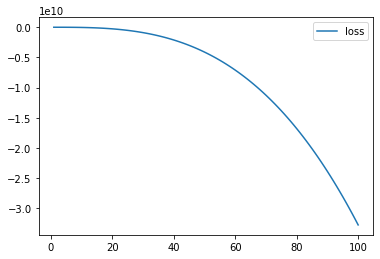

In [51]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

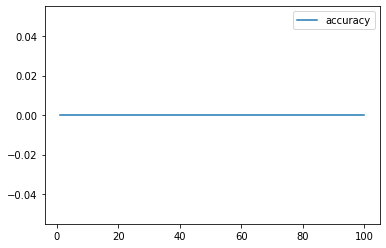

In [52]:
# Plot the accuracy
history_df.plot(y="accuracy")